# Generalized Lotka Volterra: joint alternate estimation for inverse problem

TODO

**In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\theta$**. The dynamic, boundary and initial condition losses will be the same as in the [introductory notebook](https://mia_jinns.gitlab.io/jinns/Notebooks/Tutorials/implementing_your_own_PDE_problem/) but we will also **make use of available observations** and we will also **differentiate the dynamic loss with respect to the equation parameter $\theta$**.

We will work with the Burgers equation:

$$
\begin{equation}
\tag{PDE}
\begin{cases}
&\frac{\partial}{\partial t} u_\nu(t,x) + u_\nu(t,x)\frac{\partial}{\partial x} u_\nu(t,x) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t,x) = 0,  \forall (t,x)\in I\times\Omega,&\text{ (Dynamic)} \\
&u_\nu(0, x) = -\sin(\pi x), \forall x\in\partial\Omega, &\text{ (initial condition)}\\
&u_\nu(t,-1)=u_\nu(t,1)=0, \forall t\in I, &\text{ (boundary condition)}
\end{cases}
\end{equation}
$$

We choose the time interval $I=[0,1]$ and the domain $\Omega=[-1,1]$. We denote by $\partial\Omega$ the boundary domain.

Therefore, we aim at solving:

$$
\hat{\nu},\hat{\theta}=\text{argmin}_{\nu,\theta} \mathcal{L}(\nu,\theta)
$$
with the loss:

$$
\begin{align*}
\mathcal{L}(\nu,\theta)&=\sum_{i}^{n_x}\sum_j^{n_t}\Big(u_\nu(t_j,x_i) + u_\nu(t_j,x_i)\frac{\partial}{\partial x}
          u_\nu(t_j,x_i) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t_j,x_i)\Big)^2\\
&+w_{ic}\sum_i^{nx}\Big(u_\nu(0,x_i)-(-\sin(\pi x_i))\Big)^2\\
&+w_{bc}\sum_j^{n_t}\Big[\Big(u_\nu(t_j,-1)\Big)^2+\Big(u_\nu(t_j,1)\Big)^2\Big]
\end{align*}
$$

**Note that this approach could be much more refined by working on the optimization scheme**: alternative optimizers for $\nu$ and $\theta$, pre-training for $\nu$ only, etc. This tutorial only gives a first idea on how to tackle inverse problems with **jinns**.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt

figsize = (3, 3)
plt.rcParams["figure.figsize"] = figsize

In [4]:
key = jax.random.PRNGKey(42)

## Define the equation parameters

Time domain

In [5]:
tmin = 0
tmax = 1

Tmax = 30

In [6]:
# initial conditions for each species
import numpy as onp

N_0 = onp.array([10.0, 7.0, 4.0])
# growth rates for each species
growth_rates = jnp.array([0.1, 0.5, 0.8])
# carrying capacity for each species
carrying_capacities = jnp.array([0.04, 0.02, 0.02])
# interactions
# NOTE that interaction with oneself is 0
# NOTE minus sign
interactions = (
    -jnp.array([0, 0.001, 0.001]),
    -jnp.array([0.001, 0, 0.001]),
    -jnp.array([0.001, 0.001, 0]),
)

In [7]:
key, subkey = jax.random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=5000,
    tmin=tmin,
    tmax=tmax,
    method="uniform",
    temporal_batch_size=None,
)

ts = val_data.times.sort(axis=0).squeeze()

## Observations

We use observations obtained from a run of a ground truth solver/

In [8]:
import numpy as np
from scipy.integrate import odeint

# NOTE the following line is not accurate as it skips one batch


def lotka_volterra_log(y_log, t, eq_params):
    """
    Generalized Lotka-Volterra model for N bacterial species, with logarithmic transformation for stability.

    Parameters:
        y_log (array): Array of log-transformed bacterial populations.
        t (float): Time.
        params (tuple): Tuple of model parameters.

    Returns:
        dydt (array): Array of derivative of log-transformed bacterial populations with respect to time.
    """
    alpha, beta, gamma, _ = eq_params
    N = len(y_log)
    y = np.exp(y_log)
    dydt = np.zeros(N)

    for i in range(N):
        dydt[i] = y[i] * (
            alpha[i]
            - beta[i] * np.sum(y)
            - np.sum([gamma[j][i] * y[j] for j in range(N)])
        )

    dydt_log = dydt / y

    return dydt_log


# Define name bacteria
names = ["N1", "N2", "N3"]
N = len(names)

# Define model parameters
death_rates = None
eq_params = (growth_rates, carrying_capacities, interactions, death_rates)

# Define initial bacterial populations
y0 = [10, 7, 4]

# Define time points
Tmax = 30
t = ts * Tmax

############################

y0_log = np.log(y0)
y_log = odeint(lotka_volterra_log, y0_log, t, args=(eq_params,))
y = np.exp(y_log)

In [9]:
n = 5000
subsample_size = 8
subsample = jnp.arange(n)
subsample = subsample[:: int(n / (subsample_size - 1))]
subsample = jnp.append(subsample[:-1], n - 1)
t_subsample = ts[subsample]
log_obs_subsample = y_log[subsample]

__Optionally blur the observed values__

In [10]:
noise_level = 0.2

key, subkey = jax.random.split(key)
log_noise = noise_level * jax.random.normal(subkey, shape=log_obs_subsample.shape)
log_obs_subsample_noisy = log_obs_subsample + log_noise

**Visualize the noisy observations**

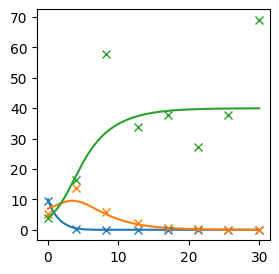

In [32]:
plt.plot(ts * Tmax, y)
plt.gca().set_prop_cycle(None)
plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
plt.show()

## Estimate the solution to the Burgers equation as well as the viscosity coefficient

*Define the domain and the associated data generator*

In [12]:
key, subkey = jax.random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey, nt=5000, tmin=tmin, tmax=tmax, temporal_batch_size=512, method="uniform"
)

*Define the data generator for the observations*

In [13]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    key=subkey,
    obs_batch_size=subsample_size,
    observed_pinn_in=t_subsample,
    observed_values=log_obs_subsample_noisy,
)

*Define the PINN*

Create the neural network architecture for the PINN with `equinox`.

In [14]:
eqx_list = (
    (eqx.nn.Linear, 1, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 3),
    (jnp.exp,),
)
key, subkey = jax.random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

*Define the jinns parameter object. **Equation parameters are initialized to 0 everywhere!!!***

In [15]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "carrying_capacities": jnp.zeros_like(carrying_capacities),
        "growth_rates": jnp.zeros_like(growth_rates),
        "interactions": jax.tree.map(jnp.zeros_like, interactions),
    },
)

*Define the loss weights*

In [16]:
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=1, initial_condition=1 * Tmax, observations=1
)

*Define the dynamic loss term*

In [17]:
dynamic_loss = jinns.loss.GeneralizedLotkaVolterra(Tmax=Tmax)

*Define how to differentiate each term of the loss* Note that the main `params` of the problem must be passed since we use the `from_str()` constructor

In [18]:
derivative_keys = jinns.parameters.DerivativeKeysODE.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params=True,
        eq_params={
            "carrying_capacities": True,
            "growth_rates": True,
            "interactions": True,
        },
    ),
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params,
)

*Define the ODE PINN losses*

In [19]:
loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(jnp.array([y0[0], y0[1], y0[2]]))),
    params=init_params,
)

*Up to this point, the content is the same as in the joint vanilla estimation tutorial in the Burgers case. But here we diverge. We will need to construct the object needed for the `jinns.solve_alternate()` call. And, first of all, we will start with a PINN pretraining of observations only. One argument in favor of such pretraining is that we will start the alternate procedure with a number of iterations on $\theta$ only: to avoid a collapse to $0$, it would be useful for the PINN to be pretrained.*

In [20]:
pretrain_loss = eqx.tree_at(
    lambda pt: (
        pt.loss_weights.dyn_loss,
        pt.loss_weights.initial_condition,
    ),
    loss,
    (0.0, 0.0),
)
pretrain_tx = optax.adam(learning_rate=1e-3)

key, subkey = jax.random.split(key)
print("PINN initialization with observations only starting")
pretrain_params, loss_values, loss_by_term_dict, _, _, _, _, _, _, _, _, _ = (
    jinns.solve(
        n_iter=1000,
        init_params=init_params,
        data=train_data,
        optimizer=pretrain_tx,
        loss=pretrain_loss,
        obs_data=obs_data,
        print_loss_every=100,
        key=subkey,
    )
)

PINN initialization with observations only starting
Initialization time: 2.6643118858337402

Compilation took
 5.596452951431274 

[train] Iteration 0: loss value = 477.7752380371094
[train] Iteration 100: loss value = 438.02667236328125
[train] Iteration 200: loss value = 437.376220703125
[train] Iteration 300: loss value = 435.7148742675781
[train] Iteration 400: loss value = 435.1924743652344
[train] Iteration 500: loss value = 435.087646484375
[train] Iteration 600: loss value = 435.0428466796875
[train] Iteration 700: loss value = 435.0151062011719
[train] Iteration 800: loss value = 434.9961853027344
[train] Iteration 900: loss value = 434.9816589355469

Stopping main optimization loop, cause: max iteration is reached

Training took
 1.3576712608337402 


Final iteration 1000: train loss value = 434.9692077636719


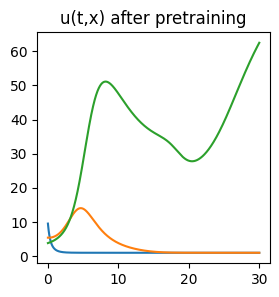

In [34]:
pretrain_u_est = jax.vmap(lambda t_x: jnp.exp(u(t_x, pretrain_params)))

plt.plot(ts * Tmax, pretrain_u_est(ts))
# plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), 'x')
plt.title("u(t,x) after pretraining")
plt.show()

In [22]:
assert jnp.allclose(
    loss_values, loss_by_term_dict.observations
)  # check that we only use observations

*We know start the alternate training*

In [51]:
# number of alternate iterations
n_iter = 30
# number of iterations for each solver
n_iter_by_solver = jinns.parameters.Params(
    nn_params=200,
    eq_params={
        "carrying_capacities": 200,
        "growth_rates": 200,
        "interactions": 200,
    },
)
# solver for each set of parameters
optimizers = jinns.parameters.Params(
    nn_params=optax.adamw(learning_rate=1e-3),
    eq_params={
        "carrying_capacities": optax.adam(learning_rate=1e-4),
        "growth_rates": optax.adam(learning_rate=1e-4),
        "interactions": optax.adam(learning_rate=1e-4),
    },
)

In [52]:
params, loss_values, loss_by_term_dict, _, _, _, stored_params, _, _, _ = (
    jinns.solve_alternate(
        n_iter=n_iter,
        n_iter_by_solver=n_iter_by_solver,
        init_params=pretrain_params,
        data=train_data,
        loss=loss,  # take the complete loss!
        optimizers=optimizers,
        verbose=True,
        obs_data=obs_data,
        key=subkey,
    )
)

Initialization time: 15.682803630828857
Alternate iteration 0: loss value = 791.2269897460938

Stopping main optimization loop, cause: max iteration is reached

Final alternate iteration 1: train loss value = 791.2269897460938

Training took
 0.4929492473602295 



## Results

Error on parameters

*Plot the loss values*

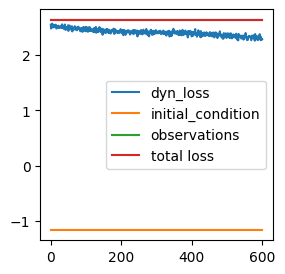

In [53]:
for loss_name, loss_values in loss_by_term_dict.items():
    # if loss_name == "observations":
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(loss_values), label="total loss")
plt.legend()
plt.show()

In [54]:
from jinns.parameters import EqParams

true_params = EqParams(
    {
        "carrying_capacities": carrying_capacities,
        "interactions": interactions,
        "growth_rates": growth_rates,
    }
)
from dataclasses import fields

for f in fields(params.eq_params):
    p = getattr(params.eq_params, f.name)
    p_true = getattr(true_params, f.name)

    rmse = jnp.mean(
        jax.tree.reduce(  # the tree.reduce does not have an effect on carrying_capacities and growth_rates
            lambda a, b: (a + b) / 2,
            jax.tree.map(lambda p1, p2: (p1 - p2) ** 2, p, p_true),
            0,
        )
    )
    print(f.name, "estimated:", p, "true:", p_true, "\n Error", rmse, "\n")

carrying_capacities estimated: [ 0.01885171  0.01798199 -0.00914192] true: [0.04 0.02 0.02] 
 Error 0.0002167623 

growth_rates estimated: [-0.01957511 -0.01941228 -0.00204106] true: [0.1 0.5 0.8] 
 Error 0.15455954 

interactions estimated: (Array([0.01935381, 0.01921292, 0.01731193], dtype=float32), Array([-0.01896803, -0.02084384,  0.01827983], dtype=float32), Array([-0.0180415 , -0.0180984 ,  0.00681905], dtype=float32)) true: (Array([-0.   , -0.001, -0.001], dtype=float32), Array([-0.001, -0.   , -0.001], dtype=float32), Array([-0.001, -0.001, -0.   ], dtype=float32)) 
 Error 0.000245566 



Error on the curves

In [55]:
trained_u_est = jax.vmap(lambda t_x: jnp.exp(u(t_x, params)))

In [56]:
# Profiled error
rmse = jnp.sum(
    jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(y, trained_u_est(ts))
)
print("RMSE profiled error", rmse)

# Reconstructed error

RMSE profiled error 218.0143


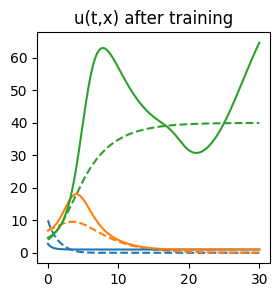

In [57]:
plt.plot(ts * Tmax, y, linestyle="--")
plt.gca().set_prop_cycle(None)
plt.plot(ts * Tmax, trained_u_est(ts))
# plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), 'x')
plt.title("u(t,x) after training")
plt.show()